In [35]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.10.12
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})

# Make output directory
if not os.path.exists('output'):
    os.makedirs('output')

import warnings
warnings.filterwarnings("ignore")

In [23]:
# load the data 
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data'
                  , header=None, sep=',', engine='python')

display(data.head(3))
print('%d rows and %d columns' % (data.shape))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


452 rows and 280 columns


In [24]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16])

In [25]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

In [26]:
data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

In [27]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 275 columns


In [28]:
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [29]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [30]:
# splitting the dataset to training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [37]:
print(y_test.shape)

(91,)


In [31]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [32]:
class LogisticRegression(object):

    def __init__(self, eta=0.05, n_epoch=100, random_state=1):
        """Feel free to change the hyperparameters"""
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            gradient_weights, gradient_bias = self.gradient(X, output, y)
            self.w_[1:] += self.eta * gradient_weights
            self.w_[0] += self.eta * gradient_bias
            cost = self.loss(output, y)
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate cross entropy loss"""  
        return -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))

    def gradient(self, X, output, y):
        """Calculate the partial derivative of cross entropy loss with respect to weights"""
        errors = (y - output)
        return errors.dot(X), errors.sum()

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-z))

    def predict(self, X):
        """Return class label after unit step"""
        net_input = self.net_input(X)
        probabilities = self.activation(net_input)
        return np.where(probabilities >= 0.5, 1, 0)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

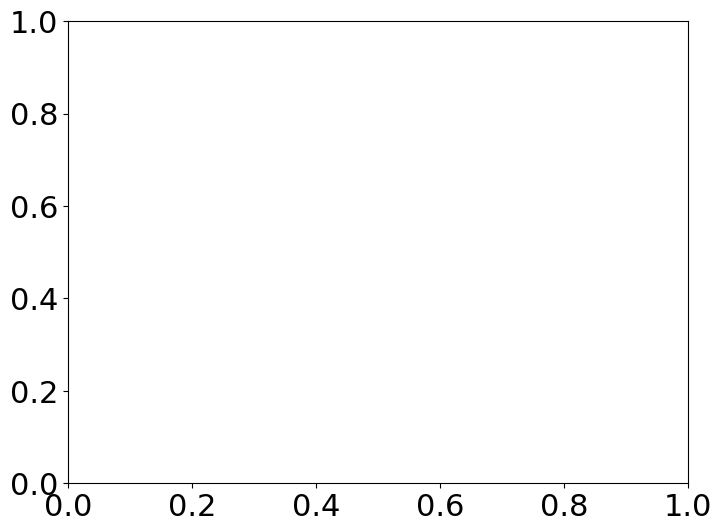

In [38]:
weights, params = [], []
for c in np.arange(-5, 5, dtype='float32'):
    lr = LogisticRegression(eta=10.**c, n_epoch=1000, random_state=1)
    lr.fit(X_train_std, y_train)
    # get the coefficients of w
    weights.append(lr.w_[0])
    params.append(10.**c)

fig, ax = plt.subplots(figsize=(8,6))
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1],
         label='Petal width', linestyle='--')
plt.xlim(10**4, 10**-5)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Weight coefficient')
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend(loc=1, prop={'size': 20})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-c.png', dpi=300)
plt.show()

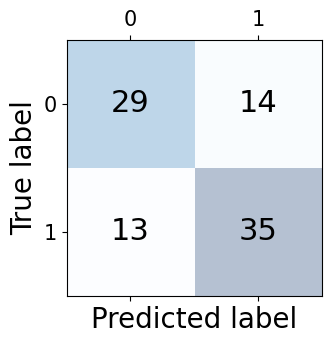

In [36]:
lr = LogisticRegression(eta=0.05, n_epoch=100, random_state=1)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('./output/fig-logistic-regression-confusion.png', dpi=300)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()